# Two-Stage Neural Network Training Pipeline

This notebook implements a two-stage training pipeline:
1. **Stage 1**: Metric Learning using triplet loss
2. **Stage 2**: Score Calibration using regression

## Imports and Configuration

In [31]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, WeightedRandomSampler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd
import importlib
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns

# Import our modular code with automatic reloading
import nn_models
import datasets
import utils

# Reload modules to get latest changes
importlib.reload(nn_models)
importlib.reload(datasets)
importlib.reload(utils)

# Import classes after reload
from nn_models import FinalSpecialistNN, SimpleRegressorNN
from datasets import RankedTripletDataset, RegressorFeatureDataset
from utils import load_full_dataset, get_sampler_weights, fit_and_transform_pca

print("All modules imported and reloaded successfully!")

All modules imported and reloaded successfully!


In [32]:
# --- CONFIGURATION ---
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

# PCA & Model Dims
N_COMPONENTS_A = 87
N_COMPONENTS_BCD = 827
LATENT_DIM = 128
REGRESSOR_INPUT_DIM = LATENT_DIM * 3 # 128 (rule) + 128 (event) + 128 (gap) = 384

# Stage 1 (Metric Learner) Config
STAGE1_LR = 0.0007566667864100958
STAGE1_BATCH_SIZE = 256 # Larger batch is better for in-batch mining
STAGE1_EPOCHS = 50  # Reduced for testing
STAGE1_TRIPLET_MARGIN = 1.0
FROZEN_MODEL_PATH = "frozen_specialist_model.pth"

# Stage 2 (Score Calibrator) Config
STAGE2_LR = 0.000367734682650636
STAGE2_BATCH_SIZE = 128
STAGE2_EPOCHS = 80  # Reduced for testing
FINAL_MODEL_PATH = "final_regressor_model.pth"

print("Configuration loaded successfully!")

Using device: cuda
Configuration loaded successfully!


## Data Loading and Preprocessing

In [33]:
# Load Data
full_data = load_full_dataset('/home/jerryjose/DA5401/DA5401-data_challenge/data/train_data_embedded.json')
print(f"Loaded dataset with shape: {full_data.shape}")
print(f"Columns: {full_data.columns.tolist()}")

Loaded dataset with shape: (4996, 9)
Columns: ['index', 'metric_name', 'user_prompt', 'response', 'system_prompt', 'score', 'main_metric', 'metric_id', 'metric_vector']


In [34]:
# Drop metric_id classes with only one member and print their details
counts = full_data['metric_id'].value_counts()
singles = counts[counts == 1].index.tolist()
if singles:
    print(f"Dropping {len(singles)} metric_id(s) that have only one sample:")
    for m_id in singles:
        rows = full_data[full_data['metric_id'] == m_id]
        print(f" - metric_id: {m_id} | metric_name: {rows['metric_name'].iloc[0] if len(rows) > 0 else 'N/A'} | indices: {rows.index.tolist()}")
    # remove singleton classes
    full_data = full_data[~full_data['metric_id'].isin(singles)].reset_index(drop=True)
else:
    print("No metric_id with only one sample found.")

if full_data.empty:
    raise ValueError("All data removed after dropping singleton classes. Cannot proceed.")

print(f"Final dataset shape after removing singletons: {full_data.shape}")

No metric_id with only one sample found.
Final dataset shape after removing singletons: (4996, 9)


In [35]:
# Train/Val Split
df_train, df_val = train_test_split(
    full_data,
    test_size=0.2,
    random_state=42,
    stratify=full_data['metric_id']
)

print(f"Training set shape: {df_train.shape}")
print(f"Validation set shape: {df_val.shape}")
print(f"Training metric_id distribution: {df_train['metric_id'].value_counts().head()}")

Training set shape: (3996, 9)
Validation set shape: (1000, 9)
Training metric_id distribution: metric_id
120    45
112    43
139    41
50     41
102    41
Name: count, dtype: int64


In [36]:
# Run PCA Pipeline and save transformers
import joblib

result = fit_and_transform_pca(df_train, df_val, N_COMPONENTS_A, N_COMPONENTS_BCD)
a_pca_train, bcd_pca_train, a_pca_val, bcd_pca_val, pca_transformers = result

# Save the fitted transformers for test pipeline
joblib.dump(pca_transformers, 'pca_transformers.pkl')
print("PCA transformers saved to 'pca_transformers.pkl'")

print(f"PCA Train A shape: {a_pca_train.shape}")
print(f"PCA Train BCD shape: {bcd_pca_train.shape}")
print(f"PCA Val A shape: {a_pca_val.shape}")
print(f"PCA Val BCD shape: {bcd_pca_val.shape}")

Starting leak-proof PCA pipeline...
Stacking raw vectors...
Fitting Scalers and PCA models on *training data only*...
Fitting Scalers and PCA models on *training data only*...
Transforming all data with fitted models...
Transforming all data with fitted models...
PCA transformation complete.
PCA transformers saved to 'pca_transformers.pkl'
PCA Train A shape: (3996, 87)
PCA Train BCD shape: (3996, 827)
PCA Val A shape: (1000, 87)
PCA Val BCD shape: (1000, 827)
PCA transformation complete.
PCA transformers saved to 'pca_transformers.pkl'
PCA Train A shape: (3996, 87)
PCA Train BCD shape: (3996, 827)
PCA Val A shape: (1000, 87)
PCA Val BCD shape: (1000, 827)


## Stage 1: Metric Learning Training

In [37]:
def run_stage_1_training(a_pca_train, bcd_pca_train, df_train, a_pca_val, bcd_pca_val, df_val):
    """
    Trains the 2-Tower Specialist model using ranked triplet loss with dynamic margins.
    """
    print("\n--- STARTING STAGE 1: METRIC LEARNING ---")
    
    # 1. Create Datasets using new RankedTripletDataset
    train_dataset_s1 = RankedTripletDataset(a_pca_train, bcd_pca_train, df_train)
    val_dataset_s1 = RankedTripletDataset(a_pca_val, bcd_pca_val, df_val)
    
    # 2. Create DataLoaders with simple shuffling
    train_loader_s1 = DataLoader(
        train_dataset_s1,
        batch_size=STAGE1_BATCH_SIZE,
        shuffle=True,
        drop_last=True
    )
    val_loader_s1 = DataLoader(
        val_dataset_s1,
        batch_size=STAGE1_BATCH_SIZE,
        shuffle=False,
        drop_last=False
    )
    
    # 3. Init Model
    model_s1 = FinalSpecialistNN(
        rule_dims=N_COMPONENTS_A, 
        event_dims=N_COMPONENTS_BCD,
        latent_dim=LATENT_DIM
    ).to(DEVICE)
    
    # 4. Loss Function - MarginRankingLoss with margin=0.0 (dynamic margin passed during training)
    criterion_ranked = nn.MarginRankingLoss(margin=0.0)
    
    # 5. Optimizer
    optimizer_s1 = optim.Adam(model_s1.parameters(), lr=STAGE1_LR)
    
    print(f"Created model with {sum(p.numel() for p in model_s1.parameters())} parameters")
    print(f"Train dataset size: {len(train_dataset_s1)}")
    print(f"Val dataset size: {len(val_dataset_s1)}")
    print(f"Number of train batches: {len(train_loader_s1)}")
    print(f"Number of val batches: {len(val_loader_s1)}")
    
    return model_s1, train_loader_s1, val_loader_s1, criterion_ranked, optimizer_s1

In [38]:
model_s1, train_loader_s1, val_loader_s1, criterion_ranked, optimizer_s1 = run_stage_1_training(
    a_pca_train, bcd_pca_train, df_train, a_pca_val, bcd_pca_val, df_val
)


--- STARTING STAGE 1: METRIC LEARNING ---
Created model with 615936 parameters
Train dataset size: 3996
Val dataset size: 1000
Number of train batches: 15
Number of val batches: 4


Epoch 1/50, Batch 10/15, Loss: 0.0624, Avg Margin: 1.38
Stage 1 - Epoch 1/50 -- Train Loss: 0.080487 -- Val Loss: 0.042343
Epoch 2/50, Batch 10/15, Loss: 0.0316, Avg Margin: 1.49
Stage 1 - Epoch 2/50 -- Train Loss: 0.034348 -- Val Loss: 0.032849
Epoch 3/50, Batch 10/15, Loss: 0.0180, Avg Margin: 1.35
Stage 1 - Epoch 3/50 -- Train Loss: 0.019808 -- Val Loss: 0.028892
Stage 1 - Epoch 2/50 -- Train Loss: 0.034348 -- Val Loss: 0.032849
Epoch 3/50, Batch 10/15, Loss: 0.0180, Avg Margin: 1.35
Stage 1 - Epoch 3/50 -- Train Loss: 0.019808 -- Val Loss: 0.028892
Epoch 4/50, Batch 10/15, Loss: 0.0083, Avg Margin: 1.69
Stage 1 - Epoch 4/50 -- Train Loss: 0.012655 -- Val Loss: 0.028058
Epoch 5/50, Batch 10/15, Loss: 0.0083, Avg Margin: 1.36
Epoch 4/50, Batch 10/15, Loss: 0.0083, Avg Margin: 1.69
Stage 1 - Epoch 4/50 -- Train Loss: 0.012655 -- Val Loss: 0.028058
Epoch 5/50, Batch 10/15, Loss: 0.0083, Avg Margin: 1.36
Stage 1 - Epoch 5/50 -- Train Loss: 0.010394 -- Val Loss: 0.019835
Epoch 6/50, Batc

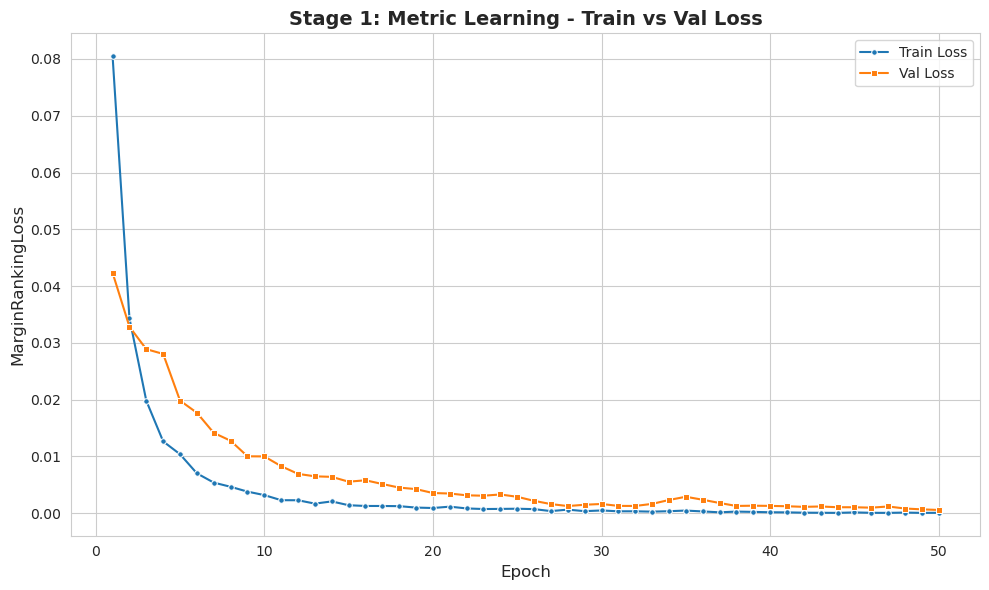


Stage 1 Loss Plot Generated


In [39]:
# Stage 1 Training Loop (Ranked Triplet Loss)
train_losses_s1 = []
val_losses_s1 = []

for epoch in range(STAGE1_EPOCHS):
    # --- Training Phase ---
    model_s1.train()
    running_train_loss = 0.0
    
    for batch_idx, (anchor, positive, neg_worse, margin) in enumerate(train_loader_s1):
        # Move all tensors to device
        anchor = anchor.to(DEVICE)
        positive = positive.to(DEVICE) 
        neg_worse = neg_worse.to(DEVICE)
        margin = margin.to(DEVICE)
        
        # Zero gradients
        optimizer_s1.zero_grad()
        
        # Embed all three vectors
        anchor_embed = model_s1.tower1(anchor)  # Rule embedding
        positive_embed = model_s1.tower2(positive)  # Better event embedding
        neg_worse_embed = model_s1.tower2(neg_worse)  # Worse event embedding
        
        # Calculate distances
        dist_positive = F.pairwise_distance(anchor_embed, positive_embed, p=2)
        dist_worse = F.pairwise_distance(anchor_embed, neg_worse_embed, p=2)
        
        # Calculate loss using MarginRankingLoss
        # We want dist_worse to be bigger than dist_positive
        target = torch.ones_like(margin)  # y=1 means we want first input > second input
        loss = criterion_ranked(dist_worse, dist_positive, target * margin)
        
        # Backward pass
        loss.backward()
        optimizer_s1.step()
        
        # Update running loss
        running_train_loss += loss.item()
        
        # Print progress every 10 batches
        if batch_idx % 10 == 0 and batch_idx > 0:
            avg_margin = margin.mean().item()
            print(f"Epoch {epoch+1}/{STAGE1_EPOCHS}, Batch {batch_idx}/{len(train_loader_s1)}, Loss: {loss.item():.4f}, Avg Margin: {avg_margin:.2f}")
    
    # Calculate average train loss
    avg_train_loss = running_train_loss / len(train_loader_s1) if len(train_loader_s1) > 0 else 0
    train_losses_s1.append(avg_train_loss)
    
    # --- Validation Phase ---
    model_s1.eval()
    running_val_loss = 0.0
    
    with torch.no_grad():
        for anchor, positive, neg_worse, margin in val_loader_s1:
            # Move all tensors to device
            anchor = anchor.to(DEVICE)
            positive = positive.to(DEVICE)
            neg_worse = neg_worse.to(DEVICE)
            margin = margin.to(DEVICE)
            
            # Embed all three vectors
            anchor_embed = model_s1.tower1(anchor)
            positive_embed = model_s1.tower2(positive)
            neg_worse_embed = model_s1.tower2(neg_worse)
            
            # Calculate distances
            dist_positive = F.pairwise_distance(anchor_embed, positive_embed, p=2)
            dist_worse = F.pairwise_distance(anchor_embed, neg_worse_embed, p=2)
            
            # Calculate loss
            target = torch.ones_like(margin)
            loss = criterion_ranked(dist_worse, dist_positive, target * margin)
            
            running_val_loss += loss.item()
    
    # Calculate average val loss
    avg_val_loss = running_val_loss / len(val_loader_s1) if len(val_loader_s1) > 0 else 0
    val_losses_s1.append(avg_val_loss)
    
    print(f"Stage 1 - Epoch {epoch+1}/{STAGE1_EPOCHS} -- Train Loss: {avg_train_loss:.6f} -- Val Loss: {avg_val_loss:.6f}")

# Save the frozen model
torch.save(model_s1.state_dict(), FROZEN_MODEL_PATH)
print(f"\nStage 1 complete. Frozen model saved to {FROZEN_MODEL_PATH}")
print(f"Final Stage 1 Train Loss: {train_losses_s1[-1]:.6f}")
print(f"Final Stage 1 Val Loss: {val_losses_s1[-1]:.6f}")

# Plot Stage 1 losses using seaborn
sns.set_style("whitegrid")
plt.figure(figsize=(10, 6))
epochs = range(1, STAGE1_EPOCHS + 1)
sns.lineplot(x=epochs, y=train_losses_s1, label='Train Loss', marker='o', markersize=4)
sns.lineplot(x=epochs, y=val_losses_s1, label='Val Loss', marker='s', markersize=4)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('MarginRankingLoss', fontsize=12)
plt.title('Stage 1: Metric Learning - Train vs Val Loss', fontsize=14, fontweight='bold')
plt.legend(fontsize=10)
plt.tight_layout()
plt.savefig('../images/stage1_loss_plot.png')
plt.show()

print(f"\nStage 1 Loss Plot Generated")

## Stage 2: Score Calibration Training

In [40]:
def setup_stage_2(a_pca_train, bcd_pca_train, y_train, a_pca_val, bcd_pca_val, y_val, df_train, frozen_model):
    """
    Setup Stage 2 training components.
    """
    print("\n--- STARTING STAGE 2: SCORE CALIBRATION ---")
    
    # 1. Create Datasets (for train and val)
    train_dataset_s2 = RegressorFeatureDataset(
        a_pca_train, bcd_pca_train, y_train, frozen_model, DEVICE
    )
    val_dataset_s2 = RegressorFeatureDataset(
        a_pca_val, bcd_pca_val, y_val, frozen_model, DEVICE
    )
    
    # 2. Create DataLoaders with simple shuffling
    train_loader_s2 = DataLoader(
        train_dataset_s2,
        batch_size=STAGE2_BATCH_SIZE,
        shuffle=True,  # Use simple shuffling
        drop_last=True
    )
    val_loader_s2 = DataLoader(
        val_dataset_s2,
        batch_size=STAGE2_BATCH_SIZE,
        shuffle=False  # No shuffling for validation
    )
    
    # 3. Init Model, Loss, Optimizer
    model_s2 = SimpleRegressorNN(input_size=REGRESSOR_INPUT_DIM).to(DEVICE)
    criterion_reg = nn.MSELoss()
    optimizer_s2 = optim.Adam(model_s2.parameters(), lr=STAGE2_LR)
    
    print(f"Created regressor with {sum(p.numel() for p in model_s2.parameters())} parameters")
    print(f"Train dataset size: {len(train_dataset_s2)}")
    print(f"Val dataset size: {len(val_dataset_s2)}")
    
    return model_s2, train_loader_s2, val_loader_s2, criterion_reg, optimizer_s2

In [41]:
# Initialize Stage 2
model_s2, train_loader_s2, val_loader_s2, criterion_reg, optimizer_s2 = setup_stage_2(
    a_pca_train, bcd_pca_train, df_train['score'].values,
    a_pca_val, bcd_pca_val, df_val['score'].values,
    df_train, model_s1
)


--- STARTING STAGE 2: SCORE CALIBRATION ---
Stage 2: Pre-computing features with frozen model...
Stage 2: Feature pre-computation complete.
Stage 2: Pre-computing features with frozen model...
Stage 2: Feature pre-computation complete.
Created regressor with 131585 parameters
Train dataset size: 3996
Val dataset size: 1000


Epoch 1/80, Batch 0/31, Loss: 85.0487
Epoch 1/80, Batch 20/31, Loss: 28.1448
Stage 2 - Epoch 1/80 -- Train MSE: 44.4999 -- Val MSE: 4.9492 -- Val RMSE: 2.2182
Epoch 2/80, Batch 0/31, Loss: 5.4943
Epoch 2/80, Batch 20/31, Loss: 5.2007
Epoch 2/80, Batch 20/31, Loss: 5.2007
Stage 2 - Epoch 2/80 -- Train MSE: 5.9971 -- Val MSE: 2.3246 -- Val RMSE: 1.5206
Epoch 3/80, Batch 0/31, Loss: 3.7857
Epoch 3/80, Batch 20/31, Loss: 3.5597
Stage 2 - Epoch 2/80 -- Train MSE: 5.9971 -- Val MSE: 2.3246 -- Val RMSE: 1.5206
Epoch 3/80, Batch 0/31, Loss: 3.7857
Epoch 3/80, Batch 20/31, Loss: 3.5597
Stage 2 - Epoch 3/80 -- Train MSE: 3.8709 -- Val MSE: 1.6918 -- Val RMSE: 1.2959
Epoch 4/80, Batch 0/31, Loss: 4.2700
Epoch 4/80, Batch 20/31, Loss: 2.5196
Stage 2 - Epoch 4/80 -- Train MSE: 3.3911 -- Val MSE: 1.3877 -- Val RMSE: 1.1721
Epoch 5/80, Batch 0/31, Loss: 3.1509
Stage 2 - Epoch 3/80 -- Train MSE: 3.8709 -- Val MSE: 1.6918 -- Val RMSE: 1.2959
Epoch 4/80, Batch 0/31, Loss: 4.2700
Epoch 4/80, Batch 20/31,

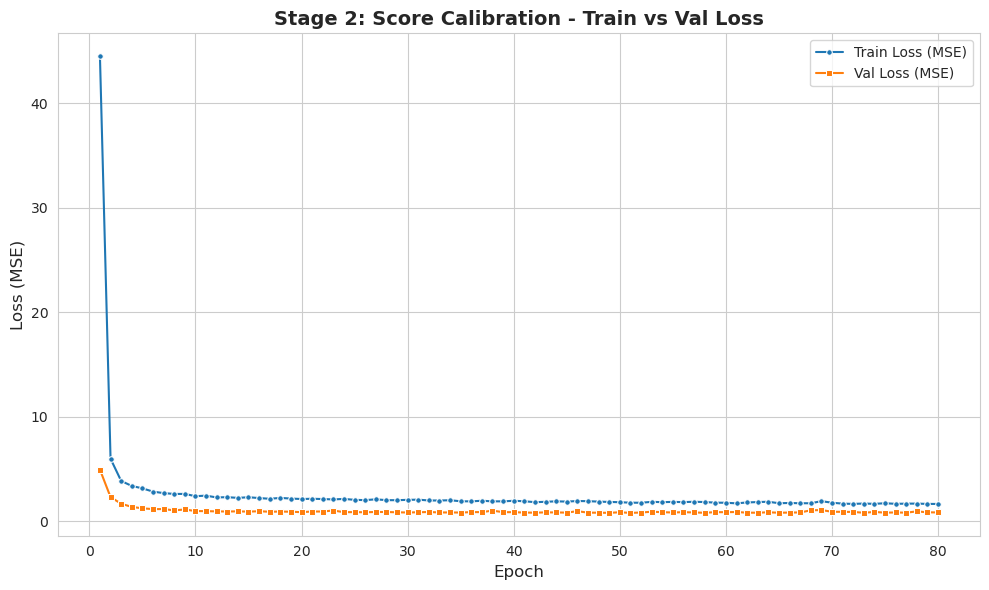


Stage 2 Loss Plot Generated


In [42]:
# Stage 2 Training Loop
train_losses_s2 = []
val_losses_s2 = []

for epoch in range(STAGE2_EPOCHS):
    # --- Training Phase ---
    model_s2.train()
    running_train_loss = 0.0
    
    for batch_idx, (features, labels) in enumerate(train_loader_s2):
        features, labels = features.to(DEVICE), labels.to(DEVICE)
        
        optimizer_s2.zero_grad()
        outputs = model_s2(features)
        loss = criterion_reg(outputs, labels)
        loss.backward()
        optimizer_s2.step()
        running_train_loss += loss.item()
        
        # Print progress every 20 batches
        if batch_idx % 20 == 0:
            print(f"Epoch {epoch+1}/{STAGE2_EPOCHS}, Batch {batch_idx}/{len(train_loader_s2)}, Loss: {loss.item():.4f}")
            
    avg_train_loss = running_train_loss / len(train_loader_s2)
    train_losses_s2.append(avg_train_loss)

    # --- Validation Phase ---
    model_s2.eval()
    running_val_loss = 0.0
    all_preds = []
    all_true = []
    with torch.no_grad():
        for features, labels in val_loader_s2:
            features, labels = features.to(DEVICE), labels.to(DEVICE)
            
            outputs = model_s2(features)
            loss = criterion_reg(outputs, labels)
            running_val_loss += loss.item()
            
            all_preds.extend(outputs.cpu().numpy())
            all_true.extend(labels.cpu().numpy())
    
    avg_val_loss = running_val_loss / len(val_loader_s2)
    val_losses_s2.append(avg_val_loss)
    val_rmse = np.sqrt(mean_squared_error(all_true, all_preds))
    
    print(f'Stage 2 - Epoch {epoch+1}/{STAGE2_EPOCHS} -- Train MSE: {avg_train_loss:.4f} -- Val MSE: {avg_val_loss:.4f} -- Val RMSE: {val_rmse:.4f}')

# Save the final model
torch.save(model_s2.state_dict(), FINAL_MODEL_PATH)
print(f"\nStage 2 complete. Final regressor saved to {FINAL_MODEL_PATH}")
print(f"Final Stage 2 Train Loss (MSE): {train_losses_s2[-1]:.4f}")
print(f"Final Stage 2 Val Loss (MSE): {val_losses_s2[-1]:.4f}")
print(f"Final Validation RMSE: {val_rmse:.4f}")

# Plot Stage 2 losses using seaborn
sns.set_style("whitegrid")
plt.figure(figsize=(10, 6))
epochs = range(1, STAGE2_EPOCHS + 1)
sns.lineplot(x=epochs, y=train_losses_s2, label='Train Loss (MSE)', marker='o', markersize=4)
sns.lineplot(x=epochs, y=val_losses_s2, label='Val Loss (MSE)', marker='s', markersize=4)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss (MSE)', fontsize=12)
plt.title('Stage 2: Score Calibration - Train vs Val Loss', fontsize=14, fontweight='bold')
plt.legend(fontsize=10)
plt.tight_layout()
plt.savefig('../images/stage2_loss_plot.png')
plt.show()

print(f"\nStage 2 Loss Plot Generated")

## Pipeline Complete

The two-stage training pipeline has finished successfully!

In [43]:
print("\n--- PIPELINE FINISHED ---")
print(f"Models saved:")
print(f"  - Stage 1 (Frozen): {FROZEN_MODEL_PATH}")
print(f"  - Stage 2 (Final): {FINAL_MODEL_PATH}")
print(f"Final Validation RMSE: {val_rmse:.4f}")

#check accuracy by rounding predictions to nearest integer and comparing to true scores
rounded_preds = np.round(all_preds)
accuracy = np.mean(rounded_preds == np.array(all_true))
print(f"Validation Accuracy (rounded predictions): {accuracy:.4f}")


--- PIPELINE FINISHED ---
Models saved:
  - Stage 1 (Frozen): frozen_specialist_model.pth
  - Stage 2 (Final): final_regressor_model.pth
Final Validation RMSE: 0.9198
Validation Accuracy (rounded predictions): 0.5890


In [44]:
def predict_from_embedded_with_position_ids(embedded_file_path, output_csv_path="test_predictions.csv"):
    """
    Run inference on pre-embedded test data using position-based IDs.
    
    Args:
        embedded_file_path: Path to the embedded test JSON file
        output_csv_path: Path to save the predictions CSV
    
    Returns:
        DataFrame with columns ['ID', 'score'] where ID is position in file (starting from 1)
    """
    print(f"Starting inference with position-based IDs...")
    print(f"Embedded file: {embedded_file_path}")
    print(f"Output: {output_csv_path}")

    import joblib
    import pandas as pd
    import numpy as np
    import torch
    import os
    
    try:
        # Step 1: Load embedded test data
        print("Step 1: Loading embedded data...")
        test_df = pd.read_json(embedded_file_path, lines=True)
        test_df['metric_vector'] = test_df['metric_name']  # For compatibility
        
        # Assign position-based IDs (starting from 1)
        test_df['ID'] = range(1, len(test_df) + 1)
        
        print(f"Loaded {len(test_df)} test samples with position-based IDs (1 to {len(test_df)})")
        
        # Step 2: Load PCA transformers and apply them
        print("Step 2: Applying saved PCA transformations...")

        if not os.path.exists('pca_transformers.pkl'):
            raise FileNotFoundError("PCA transformers not found! Please run training pipeline first.")
        
        pca_transformers = joblib.load('pca_transformers.pkl')
        scaler_A = pca_transformers['scaler_A']
        scaler_BCD = pca_transformers['scaler_BCD']
        pca_A = pca_transformers['pca_A']
        pca_BCD = pca_transformers['pca_BCD']
        
        # Extract raw embeddings
        A_test_raw = np.stack(test_df['metric_vector'].values)
        BCD_test_raw = np.concatenate([
            np.stack(test_df['user_prompt'].values),
            np.stack(test_df['system_prompt'].values),
            np.stack(test_df['response'].values)
        ], axis=1)
        
        # Apply saved transformations
        A_test_pca = pca_A.transform(scaler_A.transform(A_test_raw))
        BCD_test_pca = pca_BCD.transform(scaler_BCD.transform(BCD_test_raw))
        
        print(f"PCA applied - A: {A_test_pca.shape}, BCD: {BCD_test_pca.shape}")
        
        # Step 3: Load trained models
        print("Step 3: Loading trained models...")

        # Load Stage 1 model (frozen specialist)
        model_s1_test = FinalSpecialistNN(
            rule_dims=N_COMPONENTS_A,
            event_dims=N_COMPONENTS_BCD,
            latent_dim=LATENT_DIM
        ).to(DEVICE)
        
        if not os.path.exists(FROZEN_MODEL_PATH):
            raise FileNotFoundError(f"Frozen model not found at {FROZEN_MODEL_PATH}! Please run training first.")
        
        model_s1_test.load_state_dict(torch.load(FROZEN_MODEL_PATH, map_location=DEVICE))
        model_s1_test.eval()
        
        # Load Stage 2 model (regressor)
        model_s2_test = SimpleRegressorNN(input_size=REGRESSOR_INPUT_DIM).to(DEVICE)
        
        if not os.path.exists(FINAL_MODEL_PATH):
            raise FileNotFoundError(f"Final model not found at {FINAL_MODEL_PATH}! Please run training first.")
        
        model_s2_test.load_state_dict(torch.load(FINAL_MODEL_PATH, map_location=DEVICE))
        model_s2_test.eval()
        
        print("Models loaded successfully")
        
        # Step 4: Generate predictions
        print("Step 4: Generating predictions...")
        
        # Convert to tensors
        a_tensor = torch.tensor(A_test_pca, dtype=torch.float32).to(DEVICE)
        bcd_tensor = torch.tensor(BCD_test_pca, dtype=torch.float32).to(DEVICE)
        
        predictions = []
        batch_size = 64  # Process in batches for memory efficiency
        
        with torch.no_grad():
            for i in range(0, len(test_df), batch_size):
                end_idx = min(i + batch_size, len(test_df))
                
                # Get batch tensors
                a_batch = a_tensor[i:end_idx]
                bcd_batch = bcd_tensor[i:end_idx]
                
                # Stage 1: Generate embeddings using frozen model
                rule_embed = model_s1_test.tower1(a_batch)    # Rule embedding
                event_embed = model_s1_test.tower2(bcd_batch) # Event embedding
                gap_embed = torch.abs(rule_embed - event_embed) # Gap embedding
                
                # Concatenate features for Stage 2 regressor
                features = torch.cat([rule_embed, event_embed, gap_embed], dim=1)
                
                # Stage 2: Get score predictions from regressor
                batch_predictions = model_s2_test(features)
                predictions.extend(batch_predictions.cpu().numpy().flatten())
        
        # Step 5: Round predictions to integers and create results
        print("Step 5: Finalizing results...")
        
        rounded_predictions = np.round(predictions).astype(int)
        
        # Create results DataFrame with position-based IDs
        results_df = pd.DataFrame({
            'ID': test_df['ID'].values,  # Position-based IDs (1, 2, 3, ...)
            'score': rounded_predictions
        })
        
        # Step 6: Save results
        results_df.to_csv(output_csv_path, index=False)

        print(f"SUCCESS! Predictions saved to: {output_csv_path}")
        print(f"Generated predictions for {len(results_df)} samples")
        print(f"ID range: {results_df['ID'].min()} to {results_df['ID'].max()}")
        print(f"Prediction range: {rounded_predictions.min()} to {rounded_predictions.max()}")
        print(f"Prediction distribution:")
        print(pd.Series(rounded_predictions).value_counts().sort_index())
        
        return results_df
        
    except Exception as e:
        print(f"Error in position-based inference pipeline: {str(e)}")
        raise e



In [45]:
predict_from_embedded_with_position_ids('./data/test_data_embedded.json', 'output.csv')

Starting inference with position-based IDs...
Embedded file: ./data/test_data_embedded.json
Output: output.csv
Step 1: Loading embedded data...
Loaded 3638 test samples with position-based IDs (1 to 3638)
Step 2: Applying saved PCA transformations...
Loaded 3638 test samples with position-based IDs (1 to 3638)
Step 2: Applying saved PCA transformations...
PCA applied - A: (3638, 87), BCD: (3638, 827)
Step 3: Loading trained models...
Models loaded successfully
Step 4: Generating predictions...
Step 5: Finalizing results...
SUCCESS! Predictions saved to: output.csv
Generated predictions for 3638 samples
ID range: 1 to 3638
Prediction range: 4 to 8
Prediction distribution:
4       2
5       3
6     880
7    2000
8     753
Name: count, dtype: int64
PCA applied - A: (3638, 87), BCD: (3638, 827)
Step 3: Loading trained models...
Models loaded successfully
Step 4: Generating predictions...
Step 5: Finalizing results...
SUCCESS! Predictions saved to: output.csv
Generated predictions for 3638 

,ID,score
0,1,6
1,2,8
2,3,7
3,4,7
4,5,6
...,...,...
3633,3634,7
3634,3635,7
3635,3636,6
3636,3637,8
